<a href="https://colab.research.google.com/github/ttogle918/NLU_3-/blob/main/%EC%9A%B0%EA%B2%BD%ED%99%94_sts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLU - 문장 유사도 계산 (STS)**

## **과제 목표**

- 두 개의 한국어 문장을 입력받아 두 문장의 의미적 유사도를 출력
- regression task (0 ≤ target ≤ 5)

## **학습 데이터셋(Dataset description)**

- [KLUE-STS](https://klue-benchmark.com/tasks/67/data/download)
  - AIRBNB (에어비앤비 리뷰)
  - policy (정책 뉴스)
  - paraKOQC (스마트홈 쿼리)

  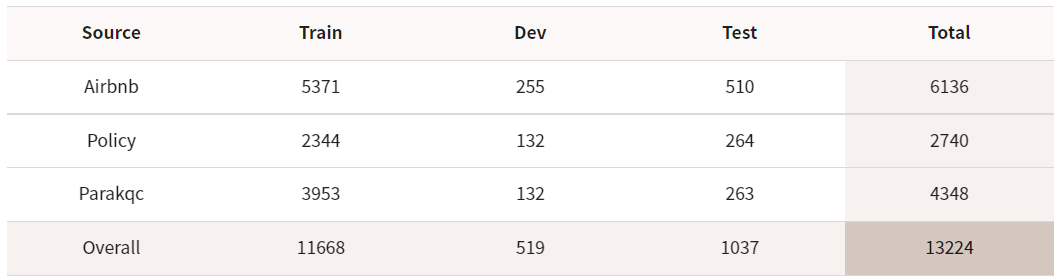

## **과제 결과물**
- 학습된 모델 (모델 자유 선택) (train set만 사용해 학습)
- 학습 방식 보고서
 - 어떤 모델을 선택했나
 - 어떻게 파라미터를 튜닝했나
 - 어떤 훈련 과정을 거쳤는가
- dev set score (F1)
- 문장 유사도를 출력하는 API (프레임워크 자유 선택)

## **설치 및 설정(Set up)**

In [ ]:
# Hugging Face의 트랜스포머 모델 설치
!pip install transformers
!pip install sentence_transformers datasets
!pip install datasets

In [2]:
# 라이브러리
import os
import sys
import re
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
import logging
import time
from datetime import datetime

import torch
import tensorflow as tf

from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, models, LoggingHandler, losses, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample

In [3]:
# logger
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.INFO,
    handlers=[LoggingHandler()],
)

## **데이터셋 불러오기(Load Dataset)**
- STS 데이터는 두 개의 문장 쌍과 이 두 문장 사이의 유사도 점수로 구성됨.
- STS데이터를 학습하여 문장과 문장간 서로 얼마나 유사한지를 예측.

In [4]:
# KLUE-STS 데이터셋 다운로드
dataset = load_dataset('klue', 'sts')

Generating train split:   0%|          | 0/11668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/519 [00:00<?, ? examples/s]

Dataset klue downloaded and prepared to /root/.cache/huggingface/datasets/klue/sts/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
# dataset 데이터셋 구조
dataset

DatasetDict({
    train: Dataset({
        features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
        num_rows: 11668
    })
    validation: Dataset({
        features: ['guid', 'source', 'sentence1', 'sentence2', 'labels'],
        num_rows: 519
    })
})

In [11]:
# dataset 데이터셋 중 train 첫째 줄 내용
dataset['train'][0]

{'guid': 'klue-sts-v1_train_00000',
 'labels': {'binary-label': 1, 'label': 3.7, 'real-label': 3.714285714285714},
 'sentence1': '숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.',
 'sentence2': '숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.',
 'source': 'airbnb-rtt'}

In [12]:
# dataset 데이터셋 중 validation 첫째 줄 내용
dataset['validation'][0]

{'guid': 'klue-sts-v1_dev_00000',
 'labels': {'binary-label': 1, 'label': 4.9, 'real-label': 4.857142857142857},
 'sentence1': '무엇보다도 호스트분들이 너무 친절하셨습니다.',
 'sentence2': '무엇보다도, 호스트들은 매우 친절했습니다.',
 'source': 'airbnb-rtt'}

### **추가 데이터셋 (kor_nlu_data)**

In [8]:
# kakaobrain/KorNLUDatasets 다운로드
kor_nlu_data = load_dataset("kor_nlu", "sts")

Generating train split:   0%|          | 0/5703 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1471 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Dataset kor_nlu downloaded and prepared to /root/.cache/huggingface/datasets/kor_nlu/sts/1.0.0/4facbba77df60b0658056ced2052633e681a50187b9428bd5752ebd59d332ba8. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
# kor_nlu_data 데이터셋 구조
kor_nlu_data

DatasetDict({
    train: Dataset({
        features: ['genre', 'filename', 'year', 'id', 'score', 'sentence1', 'sentence2'],
        num_rows: 5703
    })
    validation: Dataset({
        features: ['genre', 'filename', 'year', 'id', 'score', 'sentence1', 'sentence2'],
        num_rows: 1471
    })
    test: Dataset({
        features: ['genre', 'filename', 'year', 'id', 'score', 'sentence1', 'sentence2'],
        num_rows: 1379
    })
})

In [13]:
# kor_nlu_data 데이터셋 중 train 첫째 줄 내용
kor_nlu_data['train'][0]

{'filename': 2,
 'genre': 1,
 'id': 1,
 'score': 5.0,
 'sentence1': '비행기가 이륙하고 있다.',
 'sentence2': '비행기가 이륙하고 있다.',
 'year': 6}

In [14]:
# kor_nlu_data 데이터셋 중 test 첫째 줄 내용
kor_nlu_data['test'][0]

{'filename': 2,
 'genre': 1,
 'id': 24,
 'score': 2.5,
 'sentence1': '한 소녀가 머리를 스타일링하고 있다.',
 'sentence2': '한 소녀가 머리를 빗고 있다.',
 'year': 6}

## **데이터 전처리(Data Preprocessing)**
- KLUE-STS + kor_nlu_data 데이터셋 합치기
- 결측치 확인 후 제거
- 데이터 정제
 - 특수문자 제거
 - 한글, 영어, 숫자를 제외하고 모두 제거

In [15]:
# dataset['train'] -> 데이터프레임(DataFrame)으로 보기
import pandas as pd

sentence1, sentence2, labels1 = [], [], []

for data1 in dataset['train'] :
  sentence1.append(data1['sentence1'])
  sentence2.append(data1['sentence2'])
  labels1.append(data1['labels']['real-label'])

train_data = pd.DataFrame({'sentence1' : sentence1, 'sentence2' : sentence2, 'labels' : labels1})
train_data.head(3)

,sentence1,sentence2,labels
0,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.,3.714286
1,위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다.,시민들 스스로 자발적인 예방 노력을 한 것은 아산 뿐만이 아니었다.,0.000000
2,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘.,사람들이 주로 네이버 메일을 쓰는 이유를 알려줘,0.333333


In [16]:
# dataset['validation'] -> 데이터프레임(DataFrame)으로 보기
sentence3, sentence4, labels2 = [], [], []

for data2 in dataset['validation'] :
  sentence3.append(data2['sentence1'])
  sentence4.append(data2['sentence2'])
  labels2.append(data2['labels']['real-label'])

test_data = pd.DataFrame({'sentence1' : sentence3, 'sentence2' : sentence4, 'labels' : labels2})
test_data.head(3)

,sentence1,sentence2,labels
0,무엇보다도 호스트분들이 너무 친절하셨습니다.,"무엇보다도, 호스트들은 매우 친절했습니다.",4.857143
1,주요 관광지 모두 걸어서 이동가능합니다.,위치는 피렌체 중심가까지 걸어서 이동 가능합니다.,1.428571
2,학생들의 균형 있는 영어능력을 향상시킬 수 있는 학교 수업을 유도하기 위해 2018...,영어 영역의 경우 학생들이 한글 해석본을 암기하는 문제를 해소하기 위해 2016학년...,1.285714


In [17]:
# kor_nlu_data['train'] -> 데이터프레임(DataFrame)으로 보기
import pandas as pd

s1, s2, label1 = [], [], []

for data1 in kor_nlu_data['train'] :
  s1.append(data1['sentence1'])
  s2.append(data1['sentence2'])
  label1.append(data1['score'])

train_kor_data = pd.DataFrame({'sentence1' : s1, 'sentence2' : s2, 'labels' : label1})
train_kor_data.head(3)

,sentence1,sentence2,labels
0,비행기가 이륙하고 있다.,비행기가 이륙하고 있다.,5.0
1,한 남자가 큰 플루트를 연주하고 있다.,남자가 플루트를 연주하고 있다.,3.8
2,한 남자가 피자에 치즈를 뿌려놓고 있다.,한 남자가 구운 피자에 치즈 조각을 뿌려놓고 있다.,3.8


In [18]:
# kor_nlu_data['validation'] -> 데이터프레임(DataFrame)으로 보기
s3, s4, label2 = [], [], []

for data2 in kor_nlu_data['validation'] :
  s3.append(data2['sentence1'])
  s4.append(data2['sentence2'])
  label2.append(data2['score'])

validation_kor_data = pd.DataFrame({'sentence1' : s3, 'sentence2' : s4, 'labels' : label2})
validation_kor_data.head(3)

,sentence1,sentence2,labels
0,안전모를 가진 한 남자가 춤을 추고 있다.,안전모를 쓴 한 남자가 춤을 추고 있다.,5.00
1,어린아이가 말을 타고 있다.,아이가 말을 타고 있다.,4.75
2,한 남자가 뱀에게 쥐를 먹이고 있다.,남자가 뱀에게 쥐를 먹이고 있다.,5.00


In [19]:
# kor_nlu_data['test'] -> 데이터프레임(DataFrame)으로 보기
s5, s6, label3 = [], [], []

for data3 in kor_nlu_data['test'] :
  s5.append(data3['sentence1'])
  s6.append(data3['sentence2'])
  label3.append(data3['score'])

test_kor_data = pd.DataFrame({'sentence1' : s5, 'sentence2' : s6, 'labels' : label3})
test_kor_data.head(3)

,sentence1,sentence2,labels
0,한 소녀가 머리를 스타일링하고 있다.,한 소녀가 머리를 빗고 있다.,2.5
1,한 무리의 남자들이 해변에서 축구를 한다.,한 무리의 소년들이 해변에서 축구를 하고 있다.,3.6
2,한 여성이 다른 여성의 발목을 재고 있다.,한 여자는 다른 여자의 발목을 측정한다.,5.0


In [25]:
# KLUE-STS + kor_nlu_data 데이터셋 합치기
# concat 함수 -> 행 방향으로 데이터프레임 합치기

# add_train_data = train_data + train_kor_data
add_train_data = pd.concat([train_data, train_kor_data])

# add_test_data = test_data + test_kor_data
add_test_data = pd.concat([test_data, test_kor_data])

add_train_data

,sentence1,sentence2,labels
0,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.,3.714286
1,위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다.,시민들 스스로 자발적인 예방 노력을 한 것은 아산 뿐만이 아니었다.,0.000000
2,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘.,사람들이 주로 네이버 메일을 쓰는 이유를 알려줘,0.333333
3,"긴급 고용안정지원금은 지역고용대응 등 특별지원금, 지자체별 소상공인 지원사업, 취업...","고용보험이 1차 고용안전망이라면, 국민취업지원제도는 2차 고용안전망입니다.",0.571429
4,"호스트의 답장이 늦으나, 개선될 것으로 보입니다.",호스트 응답이 늦었지만 개선될 것으로 보입니다.,4.714286
...,...,...,...
5698,폭풍우 클로다흐가 영국을 강타하면서 심한 강풍,메르켈은 나토와 라트비아의 연대를 약속한다.,0.000000
5699,리비아 테러리스트들이 공습에 대한 복수로 찍은 수십 명의 이집트 인질들,나일강에서 더 많은 시체가 발견되면서 이집트 보트 충돌 사고 사망자 수가 증가한다.,0.000000
5700,바레인으로 향하는 대통령,시 주석 : 에볼라 퇴치를 계속 돕기 위한 중국,0.000000
5701,"중국, 인도는 양국 관계를 증진시키겠다고 맹세한다",중국은 불안한 주식 거래자들을 안심시키기 위해 뒤뚱거리고 있다.,0.000000


In [26]:
add_test_data

,sentence1,sentence2,labels
0,무엇보다도 호스트분들이 너무 친절하셨습니다.,"무엇보다도, 호스트들은 매우 친절했습니다.",4.857143
1,주요 관광지 모두 걸어서 이동가능합니다.,위치는 피렌체 중심가까지 걸어서 이동 가능합니다.,1.428571
2,학생들의 균형 있는 영어능력을 향상시킬 수 있는 학교 수업을 유도하기 위해 2018...,영어 영역의 경우 학생들이 한글 해석본을 암기하는 문제를 해소하기 위해 2016학년...,1.285714
3,"다만, 도로와 인접해서 거리의 소음이 들려요.","하지만, 길과 가깝기 때문에 거리의 소음을 들을 수 있습니다.",3.714286
4,형이 다시 캐나다 들어가야 하니 가족모임 일정은 바꾸지 마세요.,가족 모임 일정은 바꾸지 말도록 하십시오.,2.500000
...,...,...,...
1374,필리핀과 캐나다는 더 나아가 관계를 증진시키겠다고 약속한다.,필리핀은 여객선 침몰 후 100명을 구한다.,0.000000
1375,이스라엘은 팔레스타인인의 예루살렘의 구 시가지 출입을 금지한다.,팔레스타인인과 이스라엘 두 국가 해결안은 그림의 떡,1.000000
1376,비밀경호국에 대해 얼마나 알고 계십니까?,양측 의원들은 비밀경호국에 분노를 표출한다,1.000000
1377,이란 회담이 재개되면서 오바마는 사우디의 두려움을 달래기 위해 고군분투하고 있다.,미얀마는 일요일 투표를 위한 유권자 명단을 확정하기 위해 고군분투하고 있다.,0.000000


In [27]:
print(f'shape : train {add_train_data.shape}, dev {validation_kor_data.shape}, test {add_train_data.shape}')

shape : train (17371, 3), dev (1470, 3), test (17371, 3)


In [28]:
# add_train_data 데이터타입 확인
add_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17371 entries, 0 to 5702
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentence1  17371 non-null  object 
 1   sentence2  17366 non-null  object 
 2   labels     17371 non-null  float64
dtypes: float64(1), object(2)
memory usage: 542.8+ KB


In [29]:
# train 데이터 결측치 정보를 확인
add_train_data.isnull().sum()

sentence1    0
sentence2    5
labels       0
dtype: int64

In [31]:
# 결측치 제거
add_train_data = add_train_data.dropna()
validation_kor_data = validation_kor_data.dropna()
add_test_data = add_test_data.dropna()
print(f'shape : train {add_train_data.shape}, dev {validation_kor_data.shape}, test {add_train_data.shape}')

shape : train (17366, 3), dev (1470, 3), test (17366, 3)


In [38]:
# 특수문자 제거
# 한글, 영어, 숫자를 제외하고 모두 제거
def cleaning(sentence) :
  return re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', sentence)

add_train_data['sentence1'] = add_train_data['sentence1'].apply(cleaning)
add_train_data['sentence2'] = add_train_data['sentence2'].apply(cleaning)

validation_kor_data['sentence1'] = validation_kor_data['sentence1'].apply(cleaning)
validation_kor_data['sentence2'] = validation_kor_data['sentence2'].apply(cleaning)

add_test_data['sentence1'] = add_test_data['sentence1'].apply(cleaning)
add_test_data['sentence2'] = add_test_data['sentence2'].apply(cleaning)

add_train_data.head(3)

,sentence1,sentence2,labels
0,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다,3.714286
1,위반행위 조사 등을 거부 방해 기피한 자는 500만원 이하 과태료 부과 대상이다,시민들 스스로 자발적인 예방 노력을 한 것은 아산 뿐만이 아니었다,0.000000
2,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘,사람들이 주로 네이버 메일을 쓰는 이유를 알려줘,0.333333


In [40]:
# df_sts_train = add_train_data['sentence1', 'sentence2', 'labels']
# df_sts_val = validation_kor_data['sentence1', 'sentence2', 'labels']
# df_sts_test = add_test_data['sentence1', 'sentence2', 'labels']

KeyError: ignored

In [ ]:
"""
데이터 추가 후 데이터 전처리 다 했는데 위 코드부터 막힘ㅠㅠ (주석 처리 해놓음)
에러 찾아보고 여러 시도를 했지만 실패함.
아래줄에 있는 코드처럼 만들려고 했는데 뭐가 문제인지 모르겠다.
여기만 해결하면 모델 돌릴 수 있는데 뭐가 문제일까...
"""

In [ ]:
"""
데이터 추가 후 발생
계속 발생하는 에러1
KeyError: ('sentence1', 'sentence2', 'labels')
The above exception was the direct cause of the following exception:

계속 발생하는 에러2
TypeError: string indices must be integers
"""

In [ ]:
"""
잠깐 자고 일어나서 다시 위의 문제 고칠 예정.
"""

In [44]:
# klue_sts_train : 훈련용
# klue_sts_validation : 검증용
# klue_sts_test : 테스트용 (KLUE-STS validation -> test로 사용)

klue_sts_train = dataset['train']
#klue_sts_validation = validation_kor_data
klue_sts_test = dataset['validation']

- InputExample() 클래스를 통해, 두 개의 문장 쌍과 라벨을 묶어 모델이 학습할 수 있는 형태로 변환
- 배치학습을 위해 train 데이터를 DataLoader()로 묶음
- EmbeddingSimilarityEvaluator() 을 통해 모델 평가 시 사용할 test 검증기 만듦

In [49]:
def make_sts_input_example(dataset):
    ''' 
    Transform to InputExample
    ''' 
    input_examples = []
    for i, data in enumerate(dataset):
        sentence1 = data['sentence1']
        sentence2 = data['sentence2']
        score = (data['labels']['label']) / 5.0  # normalize 0 to 5
        input_examples.append(InputExample(texts=[sentence1, sentence2], label=score))

    return input_examples

In [51]:
sts_train_examples = make_sts_input_example(klue_sts_train)
#sts_valid_examples = make_sts_input_example(klue_sts_validation)
sts_test_examples = make_sts_input_example(klue_sts_test)

In [ ]:
# Train Dataloader
train_dataloader = DataLoader(
    sts_train_examples,
    shuffle=True,
    batch_size=32,
)

# validation 검증기
# dev_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
#     sts_valid_examples,
#     name="sts-dev",
# )

# test 검증기
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    sts_test_examples,
    name="sts-test",
)

## **사전학습모델 불러오기(Load Pretrained Model)**
- 임베딩모델 불러오기
- Mean Pooling(평균 풀링) 사용

- [SBERT-only-STS-training](https://colab.research.google.com/drive/1CJqg1LdNU0eMvcWYjBAE4RtDKysPKBae?usp=sharing#scrollTo=0-NWkVzvHxoe)

In [ ]:
# model : klue/roberta-base 사용
pretrained_model_name = 'klue/roberta-base'

In [ ]:
# Load Embedding Model
embedding_model = models.Transformer(
    model_name_or_path=pretrained_model_name,  # klue/roberta-base 사용
    max_seq_length=256,
    do_lower_case=True
)

# Mean Pooling(평균 풀링)만 사용. -> 문장의 모든 토큰 임베딩 벡터를 풀링함.
pooling_model = models.Pooling(
    embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False,
)

model = SentenceTransformer(modules=[embedding_model, pooling_model])

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

2022-05-26 15:03:09 - Use pytorch device: cuda




---



## **모델 훈련(Model Training)**


###**Model : klue/roberta-base**
batch_size : 16

In [ ]:
# epochs = 4, batch_size = 16
sts_num_epochs = 4
train_batch_size = 16
sts_model_save_path = 'output/training_sts-'+pretrained_model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


# CosineSimilarityLoss 사용.(loss function)
train_loss = losses.CosineSimilarityLoss(model=model)

# warm-up steps
warmup_steps = math.ceil(len(sts_train_examples) * sts_num_epochs / train_batch_size * 0.1) # 10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

# Training
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    #evaluator=dev_evaluator,
    epochs=sts_num_epochs,
    evaluation_steps=int(len(train_dataloader)*0.1),
    warmup_steps=warmup_steps,
    output_path=sts_model_save_path
)

2022-05-26 15:03:09 - Warmup-steps: 292


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

2022-05-26 15:15:34 - Save model to output/training_sts-klue-roberta-base-2022-05-26_15-03-09


## **모델 평가(Model Evaluation)**

In [ ]:
# evaluation sts-test
test_evaluator(model, output_path=sts_model_save_path)

2022-05-26 15:15:36 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2022-05-26 15:15:37 - Cosine-Similarity :	Pearson: 0.8856	Spearman: 0.8861
2022-05-26 15:15:37 - Manhattan-Distance:	Pearson: 0.8860	Spearman: 0.8817
2022-05-26 15:15:37 - Euclidean-Distance:	Pearson: 0.8866	Spearman: 0.8823
2022-05-26 15:15:37 - Dot-Product-Similarity:	Pearson: 0.8754	Spearman: 0.8724


0.8861225614244054



---


###**Model : klue/roberta-base**
batch_size : 32

In [ ]:
# epochs = 4, batch_size = 32
sts_num_epochs = 4
train_batch_size = 32
sts_model_save_path = 'output/training_sts-'+pretrained_model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


# CosineSimilarityLoss 사용.(loss function)
train_loss = losses.CosineSimilarityLoss(model=model)

# warm-up steps
warmup_steps = math.ceil(len(sts_train_examples) * sts_num_epochs / train_batch_size * 0.1) # 10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

# Training
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    #evaluator=dev_evaluator,
    epochs=sts_num_epochs,
    evaluation_steps=int(len(train_dataloader)*0.1),
    warmup_steps=warmup_steps,
    output_path=sts_model_save_path
)

2022-05-26 15:15:37 - Warmup-steps: 146


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

2022-05-26 15:27:49 - Save model to output/training_sts-klue-roberta-base-2022-05-26_15-15-37


In [ ]:
# evaluation sts-test
test_evaluator(model, output_path=sts_model_save_path)

2022-05-26 15:27:51 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2022-05-26 15:27:52 - Cosine-Similarity :	Pearson: 0.8897	Spearman: 0.8898
2022-05-26 15:27:52 - Manhattan-Distance:	Pearson: 0.8865	Spearman: 0.8843
2022-05-26 15:27:52 - Euclidean-Distance:	Pearson: 0.8874	Spearman: 0.8848
2022-05-26 15:27:52 - Dot-Product-Similarity:	Pearson: 0.8766	Spearman: 0.8741


0.8897905164663048


---


###**Model : klue/roberta-base**
batch_size : 64

In [ ]:
# epochs = 4, batch_size = 64
sts_num_epochs = 4
train_batch_size = 64
sts_model_save_path = 'output/training_sts-'+pretrained_model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


# CosineSimilarityLoss 사용.(loss function)
train_loss = losses.CosineSimilarityLoss(model=model)

# warm-up steps
warmup_steps = math.ceil(len(sts_train_examples) * sts_num_epochs / train_batch_size * 0.1) # 10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

# Training
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    #evaluator=dev_evaluator,
    epochs=sts_num_epochs,
    evaluation_steps=int(len(train_dataloader)*0.1),
    warmup_steps=warmup_steps,
    output_path=sts_model_save_path
)

2022-05-26 15:27:52 - Warmup-steps: 73


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

2022-05-26 15:40:05 - Save model to output/training_sts-klue-roberta-base-2022-05-26_15-27-52


In [ ]:
# evaluation sts-test
test_evaluator(model, output_path=sts_model_save_path)

2022-05-26 15:40:06 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2022-05-26 15:40:08 - Cosine-Similarity :	Pearson: 0.8927	Spearman: 0.8943
2022-05-26 15:40:08 - Manhattan-Distance:	Pearson: 0.8897	Spearman: 0.8875
2022-05-26 15:40:08 - Euclidean-Distance:	Pearson: 0.8897	Spearman: 0.8878
2022-05-26 15:40:08 - Dot-Product-Similarity:	Pearson: 0.8742	Spearman: 0.8728


0.8942894654072163


---


###**Model : klue/roberta-base**
batch_size : 128

In [ ]:
# epochs = 4, batch_size = 128
sts_num_epochs = 4
train_batch_size = 128
sts_model_save_path = 'output/training_sts-'+pretrained_model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


# CosineSimilarityLoss 사용.(loss function)
train_loss = losses.CosineSimilarityLoss(model=model)

# warm-up steps
warmup_steps = math.ceil(len(sts_train_examples) * sts_num_epochs / train_batch_size * 0.1) # 10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

# Training
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    #evaluator=dev_evaluator,
    epochs=sts_num_epochs,
    evaluation_steps=int(len(train_dataloader)*0.1),
    warmup_steps=warmup_steps,
    output_path=sts_model_save_path
)

2022-05-26 15:40:08 - Warmup-steps: 37


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

Iteration:   0%|          | 0/365 [00:00<?, ?it/s]

2022-05-26 15:52:18 - Save model to output/training_sts-klue-roberta-base-2022-05-26_15-40-08


In [ ]:
# evaluation sts-test
test_evaluator(model, output_path=sts_model_save_path)

2022-05-26 15:52:19 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2022-05-26 15:52:21 - Cosine-Similarity :	Pearson: 0.8908	Spearman: 0.8928
2022-05-26 15:52:21 - Manhattan-Distance:	Pearson: 0.8862	Spearman: 0.8844
2022-05-26 15:52:21 - Euclidean-Distance:	Pearson: 0.8868	Spearman: 0.8850
2022-05-26 15:52:21 - Dot-Product-Similarity:	Pearson: 0.8691	Spearman: 0.8693


0.8928077309092207

▶Model **`klue/roberta-base`**는 batch_size = 64 일 때 가장 성능이 좋음.